# PA Project (Semi weakly unsupervised learning for NLP) -- Xu Zhitong

## Part 1 -- Weakly supervised learning
### Import pre-trained BERT model(Scibert) from Huggingface. This served as a weakly supervised learning frame.

In [1]:
from transformers import BertTokenizer
from transformers import TFBertModel

model_name = "allenai/scibert_scivocab_uncased"
model = TFBertModel.from_pretrained(model_name, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

C:\Users\xuzhi\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to

## Collect data from Arxiv using paper data.ipynb, then delete all latex notation inside.

In [15]:
import pandas as pd

df = pd.read_csv("paper data.csv", index_col=0)
df.groupby('category').describe()

import numpy as np
import sklearn
import tensorflow as tf
import re

regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

x = df['abstract'].to_numpy()
y = df['category'].to_numpy()


df['encoded_cat'] = df['category'].astype('category').cat.codes

processed_x = []


for t in x:
    string_encode = t.encode("ascii", "ignore")
    t = string_encode.decode()
    new_t = re.sub(regex, '', t)
    new_t = new_t.replace('\n', ' ')
    processed_x.append(new_t)

df['processed abstract'] = processed_x

df.groupby('encoded_cat').describe()
df.to_csv('processed_labeled.csv')

In [3]:
processed_x[0]

'Conventional object-stores are built on top of traditional OS storage stack, where I/O requests typically transfers through multiple hefty and redundant layers. The complexity of object management has grown dramatically with the ever increasing requirements of performance, consistency and fault-tolerance from storage subsystems. Simply stated, more number of intermediate layers are encountered in the I/O data path, with each passing layer adding its own syntax and semantics. Thereby increasing the overheads of request processing. In this paper, through comprehensive under-the-hood analysis of an object-storage node, we characterize the impact of object-store (and user-application) workloads on the OS I/O stack and its subsequent rippling effect on the underlying object-storage devices (OSD). We observe that the legacy architecture of the OS based I/O storage stack coupled with complex data management policies leads to a performance mismatch between what an end-storage device is capabl

## Add attention mask and input ids for every abstract. Truncate to 256, and add special tokens like CLS and SEP

In [4]:
from tqdm import tqdm
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['processed abstract'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [5]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

1400it [00:03, 404.75it/s]


## Change labels from integer to one hot encoding 

In [16]:
labels = np.zeros((len(df), 7))
labels[np.arange(len(df)), df['encoded_cat'].values] = 1

In [17]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

## Convert encoded abstracts and label together into tensorflow Dataset

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1)

<TakeDataset shapes: ((256,), (256,), (7,)), types: (tf.float64, tf.float64, tf.float64)>

In [9]:
def MyMap(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

dataset = dataset.map(MyMap)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, (7,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

## Shuffle Dataset and and them to dataloader with 80/20 train-test split

In [10]:
dataset = dataset.shuffle(10000).batch(4, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (4, 256), attention_mask: (4, 256)}, (4, 7)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [11]:
p = 0.8
train_size = int((len(df)//4)*p)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## And input id layer, attention mask layer, BERT, and a fully connected layer of 512. Lastly a output layer of 7 with softmax activation

In [12]:
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(7, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sci_classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sci_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109918464   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
intermediate_layer (Dense)      (None, 512)          393728      bert[0][1]                   

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.TopKCategoricalAccuracy(k=1)

## Train this large capacity model with labeled data.

In [14]:
sci_classification_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

hist = sci_classification_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
280/280 [==============================] - 64s 203ms/step - loss: 0.7280 - top_k_categorical_accuracy: 0.7848 - val_loss: 0.2358 - val_top_k_categorical_accuracy: 0.9179
Epoch 2/10
280/280 [==============================] - 47s 166ms/step - loss: 0.2170 - top_k_categorical_accuracy: 0.9295 - val_loss: 0.1466 - val_top_k_categorical_accuracy: 0.9679
Epoch 3/10
280/280 [==============================] - 47s 169ms/step - loss: 0.1163 - top_k_categorical_accuracy: 0.9661 - val_loss: 0.0480 - val_top_k_categorical_accuracy: 0.9893
Epoch 4/10
280/280 [==============================] - 47s 168ms/step - loss: 0.0597 - top_k_categorical_accuracy: 0.9821 - val_loss: 0.0447 - val_top_k_categorical_accuracy: 0.9750
Epoch 5/10
280/280 [==============================] - 47s 168ms/step - loss: 0.0311 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.0167 - val_top_k_categorical_accuracy: 0.9929
Epoch 6/10
280/280 [==============================] - 47s 168ms/step - loss: 0.0308 - top_k_cat

In [15]:
sci_classification_model.save('sci_classification_model')

INFO:tensorflow:Assets written to: sci_classification_model\assets


INFO:tensorflow:Assets written to: sci_classification_model\assets


## Inference on unlabeled data

In [124]:
large_capacity_model = tf.keras.models.load_model('sci_classification_model')
unlabeled_abstract_df = pd.read_csv("all abstract large.csv")
unlabeled_abstract = unlabeled_abstract_df['abstract'].to_list()

In [125]:
unlabeled_abstract[0]

"this article has been withdrawn because it has been merged with the earlier article gct3 (arxiv: cs/0501076 [cs.cc]) in the series. the merged article is now available as:   geometric complexity theory iii: on deciding nonvanishing of a littlewood-richardson coefficient, journal of algebraic combinatorics, vol. 36, issue 1, 2012, pp. 103-110. (authors: ketan mulmuley, hari narayanan and milind sohoni)   the new article in this gct5 slot in the series is:   geometric complexity theory v: equivalence between blackbox derandomization of polynomial identity testing and derandomization of noether's normalization lemma, in the proceedings of focs 2012 (abstract), arxiv:1209.5993 [cs.cc] (full version) (author: ketan mulmuley)"

In [128]:
def generate_prediction_data(abstract, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(abstract)):
        token = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tf.cast(token.input_ids, tf.float64)
        masks[i, :] = tf.cast(token.attention_mask, tf.float64)
    return ids, masks


prediction_input_ids = np.zeros((len(unlabeled_abstract_df), 256))
prediction_attn_masks = np.zeros((len(unlabeled_abstract_df), 256))


pred_input_ids, pred_attn_masks = generate_prediction_data(unlabeled_abstract, prediction_input_ids, prediction_attn_masks, tokenizer)

prediction_dataset = tf.data.Dataset.from_tensor_slices((pred_input_ids, pred_attn_masks))

def MyMap(input_ids, attn_masks):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }

prediction_dataset = prediction_dataset.map(MyMap)
prediction_dataset = prediction_dataset.batch(50, drop_remainder=True)

predictions = large_capacity_model.predict(prediction_dataset)

107275it [06:11, 289.10it/s]


In [129]:
predictions[200:210]

array([[2.0751446e-05, 2.9008885e-04, 1.1985009e-04, 1.6847692e-04,
        9.9895859e-01, 3.2496220e-04, 1.1729203e-04],
       [5.3300257e-03, 5.9218812e-01, 3.7614650e-01, 1.9826228e-03,
        1.4718196e-03, 6.0300184e-03, 1.6850961e-02],
       [3.9829798e-03, 3.6297479e-01, 5.7720006e-01, 3.3404720e-03,
        3.0334960e-03, 1.8416743e-03, 4.7626521e-02],
       [5.8217184e-03, 5.3384036e-01, 2.4545614e-01, 3.8074043e-03,
        4.7289790e-03, 2.8569645e-03, 2.0348841e-01],
       [1.1899289e-04, 9.9832934e-01, 8.2672253e-05, 7.5762457e-04,
        1.6161639e-04, 2.4831842e-04, 3.0141126e-04],
       [1.3286025e-03, 1.4087663e-02, 9.7801995e-01, 7.1396073e-04,
        5.4194726e-04, 7.7376887e-04, 4.5341654e-03],
       [1.3143710e-03, 6.7139350e-02, 9.1399336e-01, 1.3839655e-03,
        1.2932300e-03, 5.6855381e-04, 1.4307286e-02],
       [3.4206673e-03, 9.5869958e-01, 1.9562954e-02, 8.6372113e-04,
        8.8953465e-04, 2.2723817e-03, 1.4291101e-02],
       [1.1983927e-04, 9

In [130]:
predictions.shape

(107250, 7)

## Part 2: top K accuracy for each category, K=1000. And serve those data with predictions back to student model

In [135]:
def get_top_k(abstracts, scores, k):
    sorted_scores = np.sort(scores)[::-1]
    threshold = sorted_scores[k]
    print(threshold)
    top_k_abstracts = []
    for index, score in enumerate(scores):
        if(score >= threshold):
            top_k_abstracts.append(abstracts[index])
    return np.array(top_k_abstracts)[0:k]


def get_top_k_final(prediction, unlabeled_abstract, k):
    abstract_0 = get_top_k(unlabeled_abstract, prediction[:,0],k)
    y_0 = np.zeros(7)
    y_0[0] = 1
    y_0_onehot = np.tile(y_0, [k, 1])
    augmented_x = abstract_0
    augmented_y = y_0_onehot
    
    for i in range(1, 7):
        abstract = get_top_k(unlabeled_abstract, prediction[:,i],k)
        y = np.zeros(7)
        y[i] = 1
        y_onehot = np.tile(y, [k, 1])
        augmented_x = np.concatenate((augmented_x, abstract), axis=0)
        augmented_y = np.concatenate((augmented_y, y_onehot), axis=0)
    return augmented_x, augmented_y



augmented_x, augmented_y = get_top_k_final(predictions, unlabeled_abstract, 10000)

0.9589703
0.88336813
0.9985216
0.9630259
0.99939835
0.9823961
0.9981273


In [145]:
augmented_y.shape

(70000, 7)

In [144]:
augmented_x.shape

(70000,)

In [146]:
index = np.argmax(augmented_y, axis=1)

In [149]:
index[1]

0

In [150]:
augmented_y[1]

array([1., 0., 0., 0., 0., 0., 0.])

In [152]:
augmented_x[1]

'we discuss a method for predicting financial movements and finding pockets of predictability in the price-series, which is built around inferring the heterogeneity of trading strategies in a multi-agent trader population. this work explores extensions to our previous framework (arxiv:physics/0506134). here we allow for more intelligent agents possessing a richer strategy set, and we no longer constrain the estimate for the heterogeneity of the agents to a probability space. we also introduce a scheme which allows the incorporation of models with a wide variety of agent types, and discuss a mechanism for the removal of bias from relevant parameters.'

In [156]:
d = {'abstract':augmented_x, 'category':index}
df_pred = pd.DataFrame(data=d)
df_pred.to_csv('all predictions.csv')

## Part 3: Feed data learnt from teacher model(BERT) into student model(LSTM)

In [1]:
import pandas as pd
import numpy as np

def re_sample(df, k):
    return df.groupby("category").sample(n=k)

df = pd.read_csv('all predictions.csv')

k = 10000

df_pred = re_sample(df, k)

augmented_x = df_pred['abstract'].to_numpy()
augmented_y = np.zeros((7*k, 7))
augmented_y[np.arange(len(df_pred)), df_pred['category'].values] = 1

In [2]:
augmented_y.shape

(70000, 7)

In [3]:
augmented_x.shape

(70000,)

In [4]:
import numpy as np
from nltk.corpus import stopwords
import re

regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
STOPWORDS = set(stopwords.words('english'))

processed_x = []
processed_y = augmented_y

for t in augmented_x:
    string_encode = t.encode("ascii", "ignore")
    t = string_encode.decode()
    new_t = re.sub(regex, '', t)
    for word in STOPWORDS:
        token = ' ' + word + ' '
        new_t = new_t.replace(token, ' ')
        new_t = new_t.replace(' ', ' ')
    processed_x.append(new_t)


In [5]:
len(processed_x)

70000

In [6]:
processed_y.shape

(70000, 7)

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import sklearn

vocab_size = 10000
embedding_dim = 256
max_length = 180
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890')
tokenizer.fit_on_texts(processed_x)
word_index = tokenizer.word_index

with open('tokenizer_LSTM.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


sequences = tokenizer.texts_to_sequences(processed_x)
padded_x = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_x, processed_y, test_size=0.30)

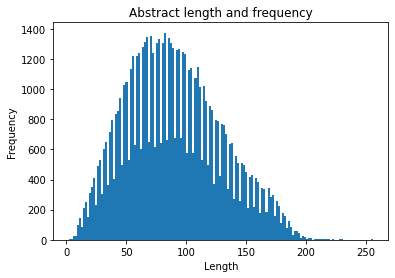

In [8]:
import matplotlib.pyplot as plt

length_arr = []
for i in sequences:
    length_arr.append(len(i))

plt.hist(length_arr, bins=150)
plt.title('Abstract length and frequency')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [9]:
padded_x.shape

(70000, 180)

In [10]:
import tensorflow as tf


sequences_input = tf.keras.Input(shape=(180,))
embeded_sequences = tf.keras.layers.Embedding(10000, 256)(sequences_input)

(lstm_sequence, forward_h, forword_c, backward_h, backward_c) = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True, return_state=True))(embeded_sequences)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_h_reshaped = tf.expand_dims(state_h, 1)
weighted_lstm = tf.keras.layers.Attention()([state_h_reshaped, lstm_sequence])

dense1 = tf.keras.layers.Dense(256, activation='relu')(weighted_lstm[:,0,:])
output = tf.keras.layers.Dense(7, activation='softmax')(dense1)

lstm_attention = tf.keras.Model(inputs=sequences_input, outputs=output)
lstm_attention.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 180, 256)     2560000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 180, 512), ( 1050624     embedding[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [11]:
acc1 = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
optim = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
lstm_attention.compile(loss='categorical_crossentropy', optimizer=optim, metrics=[acc1])
history = lstm_attention.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=512, verbose=1)

Epoch 1/3
96/96 [==============================] - 17s 135ms/step - loss: 1.0374 - top_k_categorical_accuracy: 0.5878 - val_loss: 0.2831 - val_top_k_categorical_accuracy: 0.9134
Epoch 2/3
96/96 [==============================] - 12s 130ms/step - loss: 0.1502 - top_k_categorical_accuracy: 0.9529 - val_loss: 0.1660 - val_top_k_categorical_accuracy: 0.9467
Epoch 3/3
96/96 [==============================] - 13s 131ms/step - loss: 0.0590 - top_k_categorical_accuracy: 0.9830 - val_loss: 0.1691 - val_top_k_categorical_accuracy: 0.9497


In [12]:
lstm_attention.save('student model attention')

INFO:tensorflow:Assets written to: student model attention\assets


INFO:tensorflow:Assets written to: student model attention\assets


## Part 4: Fine tuning student model(LSTM) on labeled data. Only train on last few layer, since first layers are learning general features.

In [34]:
import tensorflow as tf

base_model = tf.keras.models.load_model('student model attention')
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  9


In [23]:
'''
fine_tune_at = 2

for layer in base_model.layers[:fine_tune_at]:
    print("Type of layer:", layer.name)
    layer.trainable = False
'''

Type of layer: embedding_5
Type of layer: bidirectional_5


In [35]:
import pickle
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

vocab_size = 10000
embedding_dim = 256
max_length = 180
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
STOPWORDS = set(stopwords.words('english'))

fine_tune_df = pd.read_csv("processed_labeled.csv", index_col=0)
x = fine_tune_df['processed abstract'].to_list()
y = labels

processed_x = []

for t in x:
    string_encode = t.encode("ascii", "ignore")
    t = string_encode.decode()
    new_t = re.sub(regex, '', t)
    for word in STOPWORDS:
        token = ' ' + word + ' '
        new_t = new_t.replace(token, ' ')
        new_t = new_t.replace(' ', ' ')
    processed_x.append(new_t)


with open('tokenizer_LSTM.pickle', 'rb') as handle:
    LSTM_tokenizer = pickle.load(handle)    

sequences = LSTM_tokenizer.texts_to_sequences(processed_x)
padded_x = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [36]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_x, y, test_size=0.40)

In [37]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
acc1 = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
base_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=[acc1])
history = base_model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), verbose=1)

Epoch 1/4
27/27 [==============================] - 7s 74ms/step - loss: 0.4293 - top_k_categorical_accuracy: 0.8702 - val_loss: 0.4469 - val_top_k_categorical_accuracy: 0.8875
Epoch 2/4
27/27 [==============================] - 1s 53ms/step - loss: 0.1332 - top_k_categorical_accuracy: 0.9619 - val_loss: 0.3701 - val_top_k_categorical_accuracy: 0.8786
Epoch 3/4
27/27 [==============================] - 1s 52ms/step - loss: 0.0550 - top_k_categorical_accuracy: 0.9869 - val_loss: 0.3567 - val_top_k_categorical_accuracy: 0.9107
Epoch 4/4
27/27 [==============================] - 1s 53ms/step - loss: 0.0135 - top_k_categorical_accuracy: 0.9964 - val_loss: 0.3864 - val_top_k_categorical_accuracy: 0.9071


In [38]:
with open('LSTM_tokenizer.pickle', 'wb') as handle:
    pickle.dump(LSTM_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
base_model.save('fine_tuned_student model attention')

INFO:tensorflow:Assets written to: fine_tuned_student model attention\assets


INFO:tensorflow:Assets written to: fine_tuned_student model attention\assets


## Result Demo

In [38]:
test_abstract = ["One of the most popular estimation methods in Bayesian neural networks (BNN) is mean-field variational inference (MFVI). In this work, we show that neural networks with ReLU activation function induce posteriors, that are hard to fit with MFVI. We provide a theoretical justification for this phenomenon, study it empirically, and report the results of a series of experiments to investigate the effect of activation function on the calibration of BNNs. We find that using Leaky ReLU activations leads to more Gaussian-like weight posteriors and achieves a lower expected calibration error (ECE) than its ReLU-based counterpart.",
                "Due to the very narrow beam used in millimeter wave communication (mmWave), beam alignment (BA) is a critical issue. In this work, we investigate the issue of mmWave BA and present a novel beam alignment scheme on the basis of a machine learning strategy, Bayesian optimization (BO). In this context, we consider the beam alignment issue to be a black box function and then use BO to find the possible optimal beam pair. During the BA procedure, this strategy exploits information from the measured beam pairs to predict the best beam pair. In addition, we suggest a novel BO algorithm based on the gradient boosting regression tree model. The simulation results demonstrate the spectral efficiency performance of our proposed schemes for BA using three different surrogate models. They also demonstrate that the proposed schemes can achieve spectral efficiency with a small overhead when compared to the orthogonal match pursuit (OMP) algorithm and the Thompson sampling-based multi-armed bandit (TS-MAB) method.",
                "We quantitatively describe the main events that led to the Terra project's failure in May 2022. We first review, in a systematic way, news from heterogeneous social media sources; we discuss the fragility of the Terra project and its vicious dependence on the Anchor protocol. We hence identify the crash's trigger events, analysing hourly and transaction data for Bitcoin, Luna, and TerraUSD. Finally, using state-of-the-art techniques from network science, we study the evolution of dependency structures for 61 highly capitalised cryptocurrencies during the down-market and highlight the absence of herding behaviour.",
                "These notes shows how to do inference on the Demographic Parity (DP) metric. Although the metric is a complex statistic involving min and max computations, we propose a smooth approximation of those functions and derive its asymptotic distribution. The limit of these approximations and their gradients converge to those of the true max and min functions, wherever they exist. More importantly, when the true max and min functions are not differentiable, the approximations still are, and they provide valid asymptotic inference everywhere in the domain. We conclude with some directions on how to compute confidence intervals for DP, how to test if it is under 0.8 (the U.S. Equal Employment Opportunity Commission fairness threshold), and how to do inference in an A/B test.",
                "Emerging markets such as India provide investors with returns far greater than those in developed markets; taking the average returns from the period 1995 to 2014 the returns are 4.714% to 3.276% of the developed market. The majority of emerging markets commenced joining with the capital market of the world, thus allowing a huge inflow of capital which in turn paved the path for economic growth. Even though the emerging markets provide high returns these may also be an indication of a bubble formation. Detection of a bubble is a tedious task primarily due to the fundamental value of the security being uncertain, and the randomness of the fundamentals of the market makes detecting bubbles an arduous task. Ratios that foretold the financial crisis of 2007- Market Capitalization to GDP, Price to Earnings Ratio, Price to Book Value, Tobins Q. Data is collected from 1999-2000 from various Indian indices such as NIFTY 50, NIFTY NEXT 50, NIFTY BANK, NIFTY 500 S and PBSE SENSEX, S and P BSE 100. The paper utilizes the ratios mentioned above to detect and backtrack various bubble episodes in the Indian market; the methodology used is the Philips et al 2015 right-tailed unit test. The paper is also inclined to take steps to mitigate the effects of a bubble by amending the financial policies and the monetary liquidity of the financial system."]

with open('tokenizer_LSTM.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
processed_x_test = []

for t in test_abstract:
    string_encode = t.encode("ascii", "ignore")
    t = string_encode.decode()
    new_t = re.sub(regex, '', t)
    for word in STOPWORDS:
        token = ' ' + word + ' '
        new_t = new_t.replace(token, ' ')
        new_t = new_t.replace(' ', ' ')
    processed_x_test.append(new_t)
    
sequences_test = tokenizer.texts_to_sequences(processed_x_test)
padded_x = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
print("0 --> Business, 1 --> CS, 2 --> eess, 3 --> math, 4 --> physics, 5 --> q-bio, 6 --> stat")
predictions_test = base_model.predict(padded_x)

0 --> Business, 1 --> CS, 2 --> eess, 3 --> math, 4 --> physics, 5 --> q-bio, 6 --> stat


In [39]:
lookup = {0:'Business',1:'CS',2:'EESS', 3:'Math', 4:'Physics', 5:'Q-bio', 6:'Stat'}
def print_label(pred):
    index =  np.argmax(pred, axis=1)
    for i in index:
        print(lookup[i])

print_label(predictions_test)

Stat
EESS
CS
Stat
Business


## visualization (Auto encoder VS T-sne vs PCA)

In [40]:
sequences = LSTM_tokenizer.texts_to_sequences(processed_x)
padded_x = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [47]:
from keras.models import Model

XX = base_model.input 
YY = base_model.layers[2].output
print(base_model.layers[2].name)
new_model = Model(XX, YY)
new_model.summary()

dense_10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5_input (InputLaye [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 256)         2048000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
Total params: 3,229,952
Trainable params: 3,229,952
Non-trainable params: 0
_________________________________________________________________


In [48]:
intermediate_pred = new_model.predict(padded_x)

In [54]:
intermediate_pred.shape

(1400, 256)

In [73]:
class AUTOENCODER(Model):
    def __init__(self):
        super(AUTOENCODER, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(256,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(2, activation='relu'),
            ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AUTOENCODER()

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(intermediate_pred, intermediate_pred,
                epochs=50,
                shuffle=True,
                verbose=1)

Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 0.4464
Epoch 2/50
44/44 [==============================] - 0s 5ms/step - loss: 0.4088
Epoch 3/50
44/44 [==============================] - 0s 6ms/step - loss: 0.3993
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.3729
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.3335
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.2576
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.2031
Epoch 8/50
44/44 [==============================] - 0s 4ms/step - loss: 0.1790
Epoch 9/50
44/44 [==============================] - 0s 4ms/step - loss: 0.1660
Epoch 10/50
44/44 [==============================] - 0s 4ms/step - loss: 0.1563
Epoch 11/50
44/44 [==============================] - 0s 4ms/step - loss: 0.1483
Epoch 12/50
44/44 [==============================] - 0s 4ms/step - loss: 0.1452
Epoch 13/50
44/44 [==============================

In [76]:
ae_XX = autoencoder.encoder.input 
ae_YY = autoencoder.encoder.layers[2].output
print(autoencoder.encoder.layers[2].name)
ae_mid = Model(ae_XX, ae_YY)
ae_mid.summary()

dense_79
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_79 (Dense)             (None, 2)                 130       
Total params: 41,282
Trainable params: 41,282
Non-trainable params: 0
_________________________________________________________________


In [78]:
ae_compressed = ae_mid.predict(intermediate_pred)

In [88]:
ae_compressed.shape

(1400, 2)

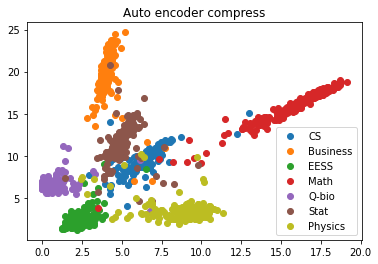

In [95]:
import matplotlib.pyplot as plt

lookup_1 = {0:'CS',1:'Business',2:'EESS', 3:'Math', 4:'Q-bio', 5:'Stat', 6:'Physics'}
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:olive']

ae_compressed_x = ae_compressed[:,0]
ae_compressed_y = ae_compressed[:,1]

for i in range(7):
    cat = lookup_1[i]
    plt.scatter(ae_compressed_x[i*200:i*200+200], ae_compressed_y[i*200:i*200+200],
               c=color[i], label=lookup_1[i])

plt.title("Auto encoder compress")
plt.legend()
plt.savefig('AE.pdf')
plt.show()

## T-sne

In [96]:
import numpy as np
from sklearn.manifold import TSNE

tsne_compressd = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(intermediate_pred)

In [97]:
tsne_compressd.shape

(1400, 2)

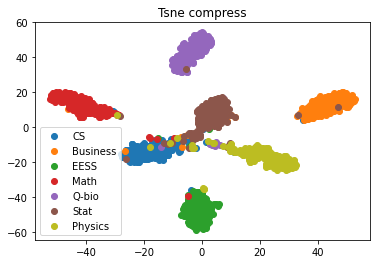

In [100]:
for i in range(7):
    cat = lookup_1[i]
    plt.scatter(tsne_compressd[:,0][i*200:i*200+200], tsne_compressd[:,1][i*200:i*200+200],
               c=color[i], label=lookup_1[i])

plt.title("Tsne compress")
plt.legend()
plt.savefig('Tsne.pdf')
plt.show()

## PCA

In [104]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_compressed = pca.fit_transform(intermediate_pred)

In [105]:
pca_compressed.shape

(1400, 2)

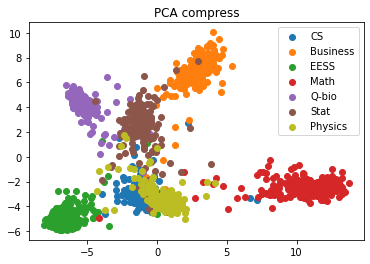

In [106]:
for i in range(7):
    cat = lookup_1[i]
    plt.scatter(pca_compressed[:,0][i*200:i*200+200], pca_compressed[:,1][i*200:i*200+200],
               c=color[i], label=lookup_1[i])

plt.title("PCA compress")
plt.legend()
plt.savefig('PCA.pdf')
plt.show()